# xblock-m timm

Based on: https://colab.research.google.com/github/johko/computer-vision-course/blob/main/notebooks/Unit%203%20-%20Vision%20Transformers/fine-tuning-multilabel-image-classification.ipynb

## Let's begin by importing the necessary modules and libraries.
---
#### Install/Update the packages if you haven't already.

In [46]:
!pip install -Uq transformers datasets timm accelerate evaluate matplotlib pandas "numpy<2" scikit-learn

  You can safely remove it manually.
  You can safely remove it manually.


In [26]:
%conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia

ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device



In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

from pathlib import Path
from PIL import Image

import datasets

from transformers.optimization import get_cosine_schedule_with_warmup

from timm import list_models, create_model
from timm.models import push_to_hf_hub

from accelerate import Accelerator, notebook_launcher

import evaluate

## Downloading the dataset
---

We'll download the [XBlock Social Screenshots 2024](https://huggingface.co/datasets/howdyaendra/xblock-social-screenshpts) dataset from the Hugging Face hub using [datasets](https://huggingface.co/docs/datasets/index) library.

In [3]:
dataset = datasets.load_dataset('howdyaendra/xblock-social-screenshots')

Resolving data files:   0%|          | 0/1618 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1618
    })
})

**The dataset contains the following features:**

- id: unique id of the sample
- image: a `PIL.Image` format image.
- height: height of the image
- width: width of the image
- label: an integer label associated with the image

For this tutorial, we'll only be needing the `image` and the `label` feature from the dataset.

These are all the unique the unique labels that are available in the dataset, 20 of them in total. Each image might have more than 1 label associated to it.

Since in the dataset, the classes are given in integer format. We'll create two mappings, `label2id` and `id2label` to convert the labels to their IDs and vice versa. It will make it easy for us to understand the labels during visualization.

In [5]:
labels = dataset["train"].features["label"].names
num_classes = len(dataset["train"].features["label"].names)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [30]:
labels
label_names=labels

## Let's now look at some samples from the dataset.
---

For any dataset we use with the `datasets` library, we can shuffle the dataset using `shuffle()` and, select any samples using the `select()` method.

As you'll notice, some of the images have more than 1 label.

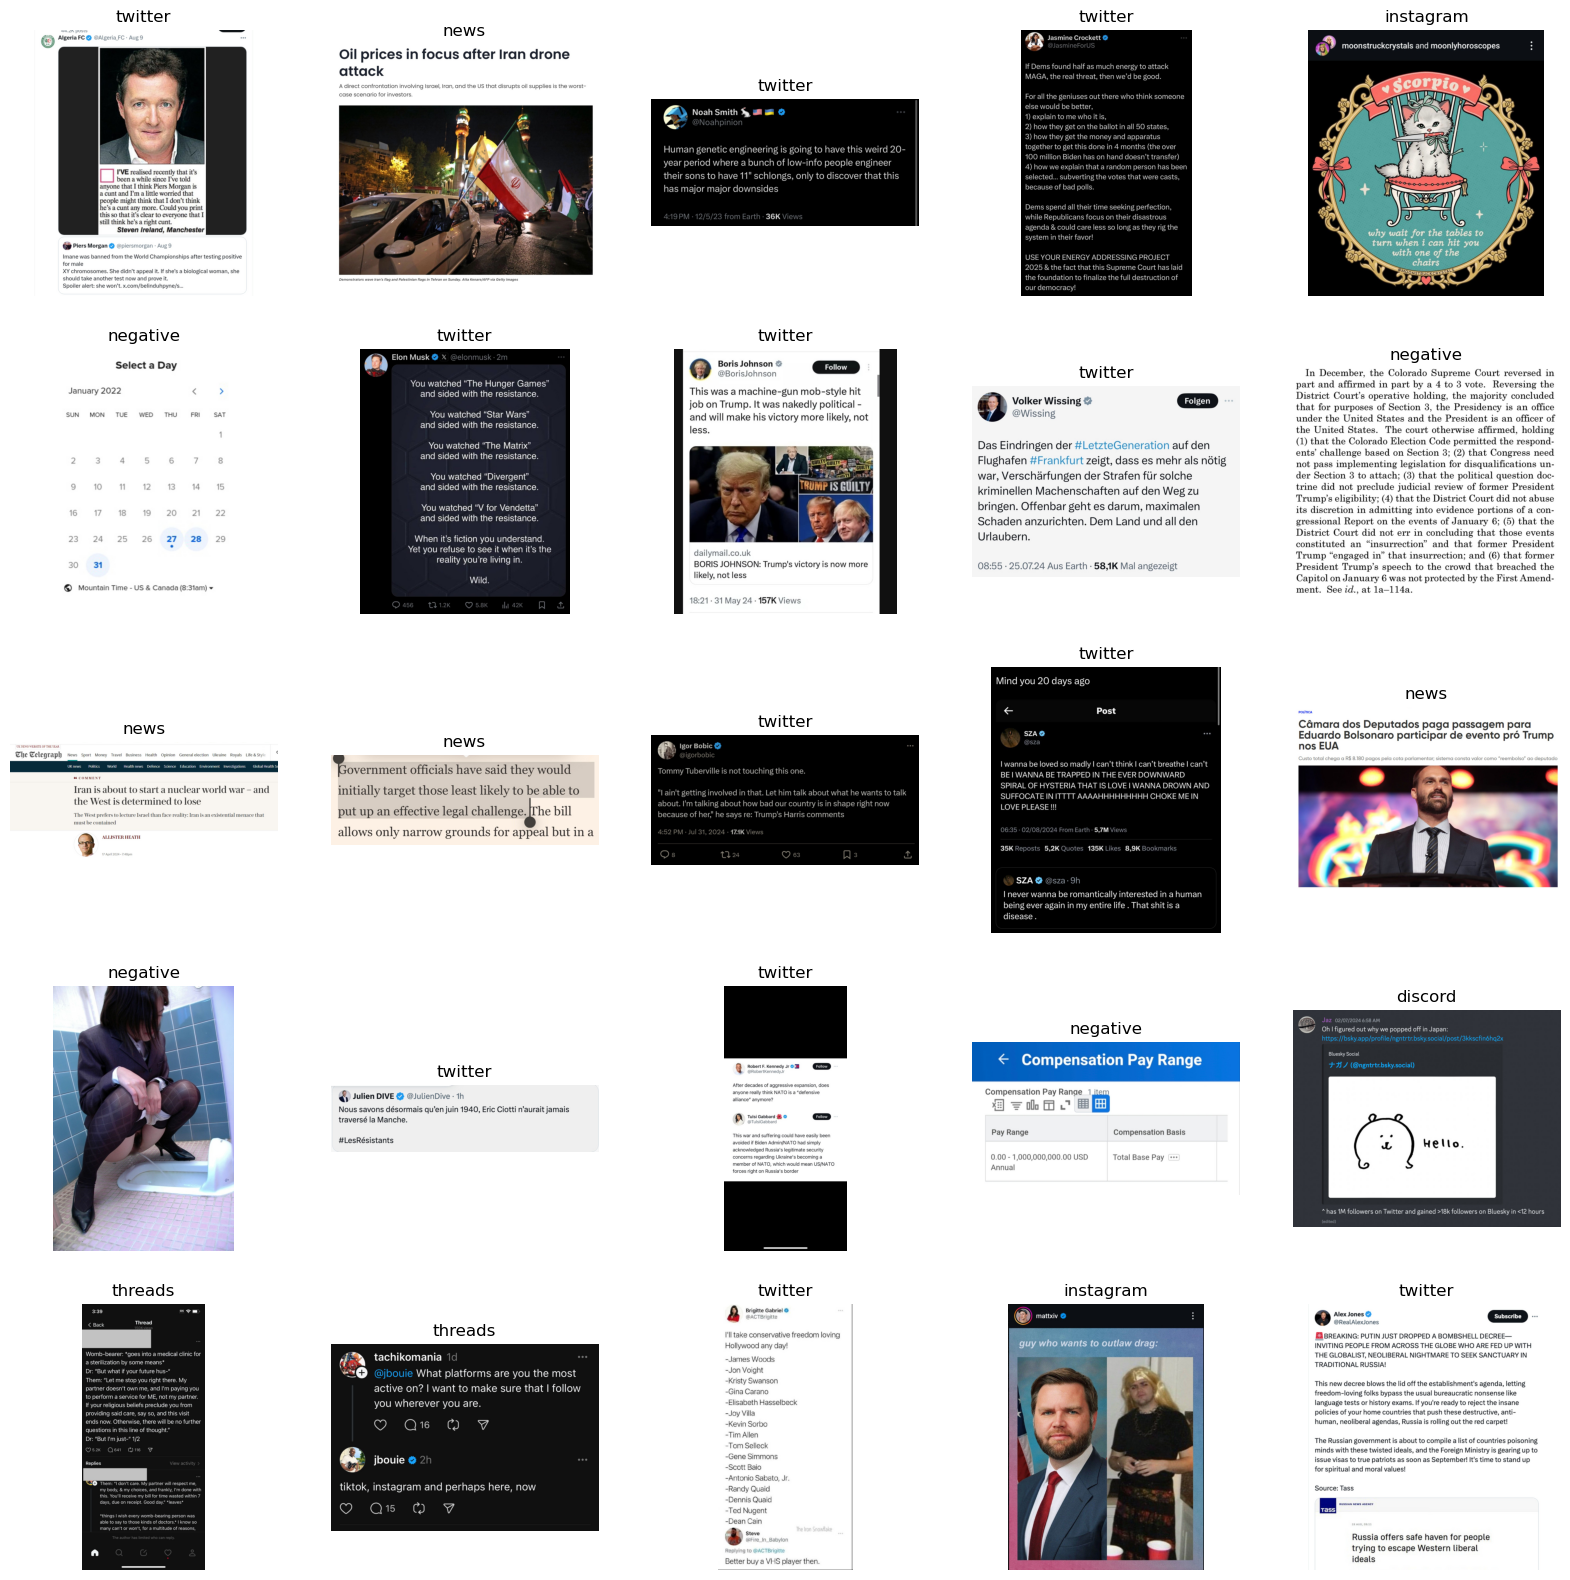

In [7]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        lb = samples[i]['label']
        # getting string labels and combining them with a comma
        labels = id2label[lb]
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(labels)
        plt.axis('off')

show_samples(dataset['train'],rows=5,cols=5)

## Preprocessing our Dataset
---

When it comes to image datasets, preprocessing involves multiple steps. Let's discuss them in detail. To apply these image and label transformations, we will define `train_transforms` and `valid_transforms` functions to preprocess a batch of samples during traning.

### Image Transforms

This includes transforms such as resizing all images to have the same dimensions, normalizing, and scaling the pixel values to a uniform range. We can also add augmentations to our images like random flips, rotations, perspectives, etc.

For our transforms and augmentations, we'll be using [torchvision](https://pytorch.org/vision/stable/index.html).

Note: we apply random augmentations such as flips, rotations, etc. to our training dataset only. Hence we'll create two different transforms `train_tfms` for training and `valid_tfms` for validation and testing.

The transforms are as follows:
- Resize: The model name `swin_s3_base_224` indicates the image input size should be 224x224, so we'll resize accordingly.
- RandomHorizontalFlip: randomly flips samples horizontally.
- RandomRotation: rotates the images in a range, here (-30,+30) degrees.
- CenterCrop: crops about the center of the image
- ToTensor: converts the PIL image to a torch.Tensor with channels-first order and scales to [0,1] range.
- Normalize: normalizes the tensor with provided mean and std. For Vision Transformers, the general mean and std used is (0.5,0.5,0.5), so we'll go with that.

### Label Transforms

Since for each sample, we have multiple labels, we'll be using `one-hot encoding` which will transform our list of labels into a vector of 0s and 1s. The length of the vector will be equal to the number of labels and, at the index of the labels, the value will be 1 and remaining as 0s.

Example:

```
label: [3,5], num_labels = 10
one-hot encoded label: [0 0 0 1 0 1 0 0 0 0], at index 3 and 5 the value will be 1
```

To do this in PyTorch, we'll be using `torch.nn.functional.one_hot` which works in the following manner:

When we pass a sample/batch to `train_transforms` or `valid_transforms` function. The `classes` will be in the form `[[3,5]]`, a list of sample labels. First we convert this list of lists into a tensor and then one-hot encode it.

Example:

```py
>>> sample_batch = [[2,14]] # batch with 1 sample
>>> labels = torch.tensor(sample_batch)
>>> labels
>>> tensor([[ 2, 14]])
>>> labels = nn.functional.one_hot(labels, num_classes=20) # provide total classes
>>> labels
>>> tensor([[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]])     
>>> labels = labels.sum(dim=1) # sum along dim=1 to get a flattened one-hot encoding
>>> labels
>>> tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]) # index 2,14 have value 1.
```

> When we apply this one-hot encoding, we are essentially converting this problem into a binary classification problem for each label.

In [8]:
img_size = (224,224)

train_tfms = T.Compose([
    T.Resize(img_size),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(
        mean = (0.5,0.5,0.5),
         std = (0.5,0.5,0.5)
    )
])

valid_tfms = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
    T.Normalize(
        mean = (0.5,0.5,0.5),
         std = (0.5,0.5,0.5)
    )
])

In [9]:
def train_transforms(batch):
    # convert all images in batch to RGB to avoid grayscale or transparent images
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    # apply torchvision.transforms per sample in the batch
    inputs = [train_tfms(x) for x in batch['image']]
    batch['pixel_values'] = inputs

    # one-hot encoding the labels
    labels = torch.tensor([[x] for x in batch['label']])
    batch['labels'] = nn.functional.one_hot(labels,num_classes=num_classes)
    batch['labels'] = batch['labels'].sum(dim=1)

    return batch

def valid_transforms(batch):
    # convert all images in batch to RGB to avoid grayscale or transparent images
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    # apply torchvision.transforms per sample in the batch
    inputs = [valid_tfms(x) for x in batch['image']]
    batch['pixel_values'] = inputs

    # one-hot encoding the labels
    labels = torch.tensor([[x] for x in batch['label']])
    batch['labels'] = nn.functional.one_hot(labels,num_classes=num_classes)
    batch['labels'] = batch['labels'].sum(dim=1)

    return batch

We'll pair the preprocessing functions with our datasets using `with_transform` method.

In [10]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

train_dataset = train_ds.with_transform(train_transforms)
valid_dataset = val_ds.with_transform(valid_transforms)
test_dataset = dataset["train"].with_transform(valid_transforms)

len(train_dataset), len(valid_dataset), len(test_dataset)

(1456, 162, 1618)

#### Data Collation

Batching our data in the correct format is collation. For `pixel_values`, the input shape for the model should be `(batch, channels, height, width)` and for our one-hot encoded `labels`, the shape should be `(batch,num_labels)`

In [16]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch]).float()
    }

**A handy function to calculate the amount of trainable parameters in our model**

In [12]:
def param_count(model):
    params = [(p.numel(),p.requires_grad) for p in model.parameters()]
    trainable = sum([count for count,trainable in params if trainable])
    total = sum([count for count,_ in params])
    frac = (trainable / total) * 100
    return total, trainable, frac

---

## Using `timm`

- We can load models from the `timm` library using `timm.create_model`.
- `timm.create_model` arguments:
    - name: name of our model,
    - num_classes: number of classes in our dataset, this will replace the pretrained classifier head of our model with a new head where output features will be equal to num_classes.
    - pretrained: True, to get the pretrained weights of our model.
    
- To list various available models, we can use `timm.list_models`. We can pass in a string pattern such as `*swin*` or `*vit*` which will match all model names available with the pattern. You also also pass `pretrained=True` to only list models with available pretrained weights. Example: `timm.list_models("*swin*",pretrained=True)`


## Writing our own training loops
---

### Components of our loops:

- **DataLoaders**:
    - to iterate over our datasets in batches, we define a dataloader using `torch.utils.data.DataLoader`.
    - we provide the per-device batch size to the dataloader
    - to enable/disable shuffling. True for training but False for validation and testing.
    - num_workers: defines the number of subprocesses which will be used to create our batches, a rule of thumb is to keep it equal to number of CPU cores.
    - collate_fn: we'll pass in the collate function we created earlier.
    
- **Loss Function**:
    - Since after one-hot encoding our labels, our task is equivalent to applying binary classification on each label, we'll be using `nn.BCEWithLogitsLoss()` which will take our predictions and targets of the shape `(batch, num_labels)`
    
- **Model**:
    - The model loaded from the `timm` library.
    
- **Optimizer, Scheduler**:
    - Optimizer updates the weights of our model
    - Scheduler handles the change in the learning rate of our model during training. We'll be using `get_cosine_schedule_with_warmup` from `transformers.optimization`. In this scheduler, the learning rate increases gradually till `num_warmup_steps` and decays for the remaining steps with cosine annealing.

- **Metrics**:
    - we'll calculate metrics using `evaluate` library. We will be using `roc_auc` metric for `multilabel` with `micro` averaging which will calculate the metrics globally. For more explanation and references about the metric, check this [evaluate space](https://huggingface.co/spaces/evaluate-metric/roc_auc).
    

## Using Accelerate to power our loops:

- Accelerate takes care of device placement of our data and model automatically. We define as `accelerator` instance with `Accelerator()` along with any further configuration kwargs.
- We pass our model, dataloaders, optimizer, scheduler via `accelerator.prepare` method.
- To calculate metrics, we need to gather our batches from all devices, hence we use `accelerator.gather_for_metrics` to do so.
- To print only on the main process, we will use `accelerator.print`.


Since we'll be running from our Jupyter notebook, we'll be using `notebook_launcher`, which will call our `train` function that contains all of our logic and `accelerator` instance.


For further information and details on how to use `accelerate`, checkout the [docs](https://huggingface.co/docs/accelerate/index) and this handy [HF space](https://huggingface.co/spaces/hf-accelerate/accelerate_examples).

In [31]:
def train(model_name,batch_size=16,epochs=1,lr=2e-4):
    """
    contains all of our training loops.
    1. define Accelerator instance
    2. define dataloaders, model, optimizer, loss function, scheduler
    3. write training, validation and testing loop.
    """

    accelerator = Accelerator() # create instance

    # define dataloaders

    train_dl = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = batch_size, # the batch_size will be per-device
        shuffle=True,
        # num_workers=4,
        collate_fn=collate_fn
    )

    valid_dl = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size = batch_size*2,
        shuffle=False,
        # num_workers=4,
        collate_fn=collate_fn
    )

    test_dl = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = batch_size*2,
        shuffle=False,
        # num_workers=4,
        collate_fn=collate_fn
    )

    # timm model
    model = create_model(
        model_name,
        pretrained = True,
        num_classes = num_classes
    ).to(accelerator.device) # device placement: accelerator.device
    
    total, trainable, frac = param_count(model)
    accelerator.print(f"{total = :,} | {trainable = :,} | {frac:.2f}%")

    # loss, optimizer, scheduler

    loss_fn = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=0.02)

    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps = int(0.1 * len(train_dl)),
        num_training_steps=len(train_dl)
    )

    model, optimizer, scheduler, train_dl, valid_dl, test_dl = accelerator.prepare(
        model, optimizer, scheduler, train_dl, valid_dl, test_dl
    )

    # loops for number of epochs
    for epoch in range(1,epochs+1):

        model.train() # set model to train

        train_metric = evaluate.load('roc_auc','multilabel') # load metric

        running_loss = 0.

        for batch in train_dl:

            logits = model(batch['pixel_values'])

            loss = loss_fn(logits,batch['labels'])
            accelerator.backward(loss) # backpropagation
            optimizer.step() # update weights
            scheduler.step() # update LR
            optimizer.zero_grad() # set grad values to zero

            running_loss += loss.item() # keep track of loss

            # prepare for metrics
            logits, labels = accelerator.gather_for_metrics(
                (logits, batch['labels'])
            )
            train_metric.add_batch(references=labels, prediction_scores=logits)

        # loss and metric over 1 epoch
        train_loss = running_loss / len(train_dl)
        train_roc_auc = train_metric.compute(average='micro')['roc_auc']

        accelerator.print(f"\n{epoch = }")
        accelerator.print(f"{train_loss = :.3f} | {train_roc_auc = :.3f}")

        # validation loop

        model.eval() # set model for evaluation

        running_loss = 0.
        valid_metric = evaluate.load('roc_auc','multilabel')

        for batch in valid_dl:

            with torch.no_grad():
                logits = model(batch['pixel_values'])

            loss = loss_fn(logits, batch['labels'])
            running_loss += loss.item()

            logits, labels = accelerator.gather_for_metrics(
                (logits, batch['labels'])
            )
            valid_metric.add_batch(references=labels, prediction_scores=logits)


        valid_loss = running_loss / len(valid_dl)
        valid_roc_auc = valid_metric.compute(average='micro')['roc_auc']

        accelerator.print(f"{valid_loss = :.3f} | {valid_roc_auc = :.3f}")

        # save model
        accelerator.save_model(model, f'./{model_name}-xblockm-timm')
        push_to_hf_hub(model, f'{model_name}-xblockm-timm', model_config=dict(label_names=label_names))

    # testing loop after all epochs are over

    test_metric = evaluate.load('roc_auc','multilabel')

    for batch in test_dl:

        with torch.no_grad():
            logits = model(batch['pixel_values'])

        logits, labels = accelerator.gather_for_metrics(
            (logits, batch['labels'])
        )
        test_metric.add_batch(references=labels, prediction_scores=logits)

    test_roc_auc = test_metric.compute(average='micro')['roc_auc']

    accelerator.print(f"\n\nTEST AUROC: {test_roc_auc:.3f}")

## Let's commence our training 🚀️🚀️🚀️

with `notebook_launcher`, we start the training procedure by calling our `train` function with the args `(model_name, batch_size, epochs, lr)` as we defined above, and `num_processes` equal to the amount of GPUs.

In [32]:
model_name = 'swin_s3_base_224'
notebook_launcher(train, (model_name,8,5,5e-5), num_processes = 1)


Launching training on one GPU.
total = 70,366,759 | trainable = 70,366,759 | 100.00%

epoch = 1
train_loss = 0.220 | train_roc_auc = 0.835
valid_loss = 0.171 | valid_roc_auc = 0.892


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/282M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/282M [00:00<?, ?B/s]


epoch = 2
train_loss = 0.161 | train_roc_auc = 0.906
valid_loss = 0.164 | valid_roc_auc = 0.915


model.safetensors:   0%|          | 0.00/282M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/282M [00:00<?, ?B/s]


epoch = 3
train_loss = 0.124 | train_roc_auc = 0.948
valid_loss = 0.135 | valid_roc_auc = 0.941


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/282M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/282M [00:00<?, ?B/s]


epoch = 4
train_loss = 0.110 | train_roc_auc = 0.960
valid_loss = 0.153 | valid_roc_auc = 0.931


model.safetensors:   0%|          | 0.00/282M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/282M [00:00<?, ?B/s]


epoch = 5
train_loss = 0.077 | train_roc_auc = 0.984
valid_loss = 0.114 | valid_roc_auc = 0.959


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/282M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/282M [00:00<?, ?B/s]



TEST AUROC: 0.983


## Looks like we've got pretty good results! Let's see how to perform inference.

- When we save a model with `accelerate.save_model`, it saves it in [safetensors format](https://huggingface.co/docs/safetensors/index).

In [165]:
# intialize the model

model = create_model(
    model_name,
    num_classes=num_classes
)

In [166]:
from safetensors.torch import load_model

In [167]:
load_model(model,f'./{model_name}-xblockm/model.safetensors')

(set(), [])

In [55]:
def show_predictions(rows=2,cols=4):
    # model.eval()
    samples = test_dataset.shuffle().select(np.arange(rows*cols))
    fig = plt.figure(figsize=(cols*4,rows*4))

    for i in range(rows*cols):

        img = samples[i]['image']

        return
        inputs = samples[i]['pixel_values'].unsqueeze(0)
        labels = [samples[i]['label']]
        labels = ','.join([id2label[lb] for lb in labels])

        with torch.no_grad():
            logits = model(inputs)

        # apply sigmoid activation to convert logits to probabilities
        # getting labels with confidence threshold of 0.5
        predictions = logits.sigmoid() > 0.5

        # converting one-hot encoded predictions back to list of labels
        predictions = predictions.float().numpy().flatten() # convert boolean predictions to float
        pred_labels = np.where(predictions>=0.8)[0] # find indices where prediction is 1
        pred_labels = ','.join([id2label[label] for label in pred_labels]) # converting integer labels to string

        label = f"labels: {labels}\npredicted: {pred_labels}"
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_predictions(rows=5,cols=5)

valid_transforms {'image': [<PIL.Image.Image image mode=RGB size=1925x2000 at 0x26342E5BCE0>], 'label': [12]}
1


<Figure size 2000x2000 with 0 Axes>

In [6]:
num_classes

13